# June 2018 AAT Run Planning

## Imports/Setup 

In [1]:
import os
import sys
import urllib
from collections import defaultdict

import numpy as np

from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord, EarthLocation, get_sun
from astropy.time import Time

import astroplan, astroplan.plots

import tqdm

from importlib import reload

In [2]:
%matplotlib inline
from matplotlib import style, pyplot as plt

## DES Hosts

Starting from Marla's file from slack listing the decals or DES hosts

In [3]:
# https://sagasurvey.slack.com/files/U050EEBV8/FAPQS72UQ/hosts_for_aat_2018a.txt

aat_hosts_str = """
   RA      Dec    NSAID   PGC#  SAGA_name des_dr1 decals_dr5 decals_dr6
------- --------- ------ ------ --------- ------- ---------- ----------
175.489  -6.15558     -1  36304               0.0        1.0        0.0
185.975  -3.44293   3469  40284               0.0        1.0        0.0
187.211  -1.93918 141465  41083               0.0        1.0        0.0
212.872  -5.04364     -1  50670               0.0        1.0        0.0
214.418  -7.41748     -1  51055               0.0        1.0        0.0
216.178  -3.21218  35340  51471               0.0        1.0        0.0
217.418   3.23331 165082  51787               0.0        1.0        0.0
219.796   5.36347 145398  52365               0.0        1.0        0.0
221.546 -0.222942 165536  52735      Dune     0.0        1.0        0.0
224.594  -1.09102 145729  53499   Othello     0.0        1.0        0.0
225.232  -7.45724     -1  53630               0.0        1.0        0.0
227.456  0.470085 145879  54119               0.0        1.0        0.0
 238.58  0.543022 146486  56337               0.0        1.0        0.0
304.322  -52.7968     -1  64427               1.0        0.0        0.0
317.967  -49.2838     -1  66318               1.0        0.0        0.0
323.147  -44.0676     -1  66934               1.0        0.0        0.0
325.054  -42.5394     -1  67146               1.0        0.0        0.0
 329.04   -49.522     -1  67663               1.0        0.0        0.0
330.137  -43.3898     -1  67817               1.0        0.0        0.0
332.143  -57.4426     -1  68128               1.0        0.0        0.0
340.468  -44.7673     -1  69521               1.0        0.0        0.0
344.306  -43.3961     -1  70094               1.0        0.0        0.0
352.181  -41.3334     -1  71548               1.0        0.0        0.0
 353.32  -54.0945     -1  71729               1.0        0.0        0.0
354.131  0.297265  61945  71883      AnaK     1.0        1.0        0.0
8.56455  -27.8037     -1   2052               1.0        0.0        0.0
11.8665  -31.4221     -1   2778               1.0        0.0        0.0
13.1765  -31.2058     -1   3089               1.0        0.0        0.0
 22.619  -22.6672     -1   5619               1.0        0.0        0.0
"""
aat_hosts = table.Table.read(aat_hosts_str, format='ascii')
aat_hosts

RA,Dec,NSAID,PGC#,SAGA_name,des_dr1,decals_dr5,decals_dr6
float64,float64,int64,int64,str7,float64,float64,float64
175.489,-6.15558,-1,36304,--,0.0,1.0,0.0
185.975,-3.44293,3469,40284,--,0.0,1.0,0.0
187.211,-1.93918,141465,41083,--,0.0,1.0,0.0
212.872,-5.04364,-1,50670,--,0.0,1.0,0.0
214.418,-7.41748,-1,51055,--,0.0,1.0,0.0
216.178,-3.21218,35340,51471,--,0.0,1.0,0.0
217.418,3.23331,165082,51787,--,0.0,1.0,0.0
219.796,5.36347,145398,52365,--,0.0,1.0,0.0
221.546,-0.222942,165536,52735,Dune,0.0,1.0,0.0


## Astroplan

First we set up the target objects from the above table

In [4]:
targets = []
for row in aat_hosts:
    coo = SkyCoord(row['RA']*u.deg, row['Dec']*u.deg)
    
    saga_host = False
    if not np.ma.is_masked(row['SAGA_name']):
        name = str(row['SAGA_name'])
        saga_host = True
    elif row['NSAID'] != -1 : 
        name = 'NSA' + str(row['NSAID'])
    else:
        name = 'PGC' + str(row['PGC#'])    
    
    target = astroplan.FixedTarget(coo, name)
    target.des1 = bool(row['des_dr1'])
    target.decals5 = bool(row['decals_dr5'])
    target.decals6 = bool(row['decals_dr6'])
    target.nsa = row['NSAID'] != -1
    target.saga_host = saga_host
    
    targets.append(target)

In [5]:
des_targets = [t for t in targets if t.des1 and not t.saga_host]
decals_targets = [t for t in targets if (t.decals5 or t.decals6) and not t.des1 and not t.saga_host]
saga_targets = [t for t in targets if t.saga_host]

In [6]:
decals_not_nsa_targets = [t for t in targets if t.nsa and not t.des1 and not t.saga_host]
nsa_targets = [t for t in targets if t.nsa and not t.des1 and not t.saga_host]

Now we identify the site and the observing run parameters

In [7]:
aat = astroplan.Observer.at_site('Anglo-Australian Observatory')

run_start = aat.midnight(Time('2018-6-10'), 'next')
run_end = aat.midnight(Time('2018-6-15'), 'next')
run_mid = aat.midnight(Time((run_start.jd + run_end.jd)/2, format='jd'))

Then we plot 'em up

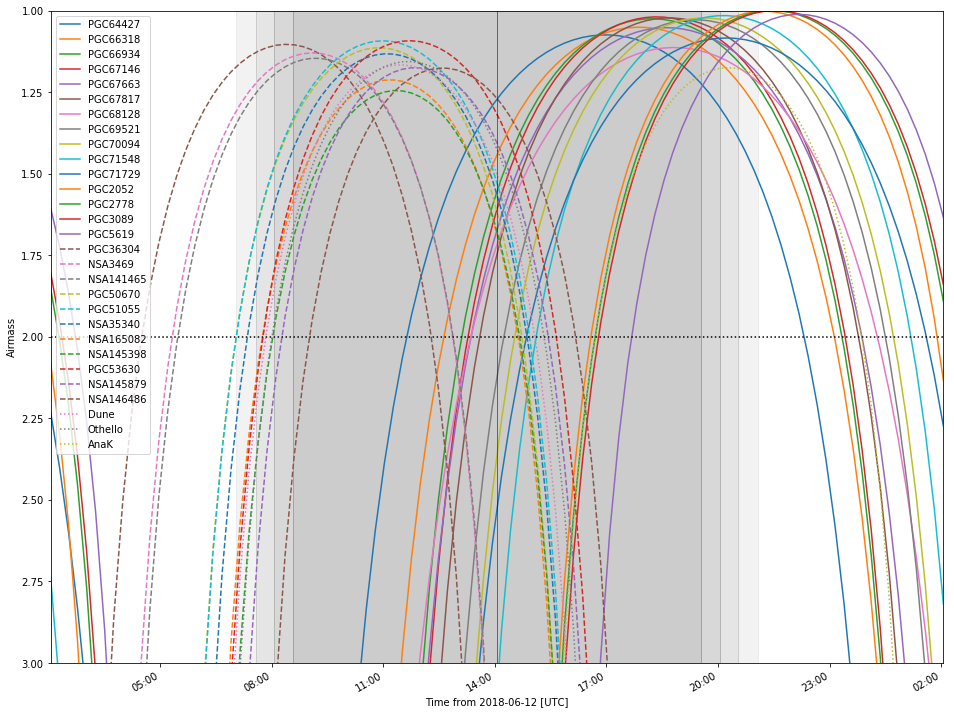

In [8]:
plt.figure(figsize=(16, 12))

astroplan.plots.plot_airmass(des_targets, aat, run_mid,
                            style_kwargs=dict(linestyle='-'))
astroplan.plots.plot_airmass(decals_targets, aat, run_mid,
                            style_kwargs=dict(linestyle='--'))
astroplan.plots.plot_airmass(saga_targets, aat, run_mid,
                            style_kwargs=dict(linestyle=':'),
                            brightness_shading=True)

plt.axhline(2, ls=':', c='k')
plt.axvline(run_mid.plot_date, c='k', lw=1, alpha=.5)
plt.legend(loc=0);

Solid lines are in DES, dashed are in DECaLS, dotted are already-observed.  

Plenty of DES targets in the second half-night.  First quarter requires DecaLS (maybe even a few previous targets if we are *really* lucky with weather), second quarter borderline.